In [1]:
%pip install imageio


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
# 코드 13-22 라이브러리 호출
import imageio  # 이미지 데이터를 읽고 쓸 수 있는 쉬운 인터페이스를 제공하는 라이브러리
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib
import matplotlib.pylab as plt

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

matplotlib.style.use("ggplot")  # ①
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 코드 13-23 변수 값 설정
batch_size = 512
epochs = 200
sample_size = 64  # ①
nz = 128  # ②
k = 1  # ③

In [4]:
# 코드 13-24 MNIST를 내려받은 후 정규화
transform = transforms.Compose(
    [
        transforms.ToTensor(),  # 이미지를 텐서로 변환
        transforms.Normalize(
            (0.5,), (0.5,)
        ),  # 이미지를 평균이 0.5, 표준편차가 0.5가 되도록 정규화
    ]
)

train_dataset = datasets.MNIST(
    root="../chap13/data", train=True, transform=transform, download=True
)

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=4
)

In [5]:
# 코드 13-25 생성자 네트워크 생성
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(
            -1, 1, 28, 28
        )  # 생성자 네트워크의 반환값은 ‘배치 크기×1×28×28’이 됩니다.

In [6]:
# 코드 13-26 판별자 네트워크 생성
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784  # 판별자의 입력 크기
        self.main = (
            nn.Sequential(  # 판별자 역시 선형 계층과 리키렐루 활성화 함수로 구성
                nn.Linear(self.n_input, 1024),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(1024, 512),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(512, 256),
                nn.LeakyReLU(0.2),
                nn.Dropout(0.3),
                nn.Linear(256, 1),
                nn.Sigmoid(),
            )
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)  # 이미지가 진짜인지 가짜인지를 분류하는 값을 반환

In [7]:
# 코드 13-27 생성자와 판별자 네트워크 초기화
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [8]:
# 코드 13-28 옵티마이저와 손실 함수 정의
optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

criterion = nn.BCELoss()

losses_g = []  # 매 에포크마다 발생하는 생성자 오차를 저장하기 위한 리스트형 변수
losses_d = []  # 매 에포크마다 발생하는 판별자 오차를 저장하기 위한 리스트형 변수
images = []  # 생성자에 의해 생성되는 이미지를 저장하기 위한 리스트형 변수

In [9]:
# 코드 13-29 생성된 이미지 저장 함수 정의
def save_generator_image(image, path):
    save_image(image, path)

In [10]:
# 코드 13-30 판별자 학습을 위한 함수
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)  # 배치 크기 정보 얻기
    real_label = torch.ones(b_size, 1).to(device)  # ①
    fake_label = torch.zeros(b_size, 1).to(device)  # ②
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(
        output_real, real_label
    )  # 진짜 데이터를 판별자에 제공하여 학습한 결과와 진짜 데이터의 레이블을 이용하여 오차를 계산
    output_fake = discriminator(data_fake)
    loss_fake = criterion(
        output_fake, fake_label
    )  # 가짜 데이터를 판별자에 제공하여 학습한 결과와 가짜 데이터의 레이블을 이용하여 오차를 계산
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return (
        loss_real + loss_fake
    )  # 진짜 데이터와 가짜 데이터의 오차가 합쳐진 최종 오차를 반환

In [11]:
# 코드 13-31 생성자 학습을 위한 함수
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)  # ①
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [13]:
# 코드 13-32 모델 학습
generator.train()  # 생성자를 학습 모드로 설정
discriminator.train()  # 판별자를 학습 모드로 설정

for epoch in range(epochs):
    loss_g = 0.0  # 생성자 오차를 추적(저장)하기 위한 변수
    loss_d = 0.0  # 판별자 오차를 추적(저장)하기 위한 변수
    for idx, data in tqdm(
        enumerate(train_loader), total=int(len(train_dataset) / train_loader.batch_size)
    ):
        image, _ = data  # 학습을 위한 이미지 데이터를 가져옵니다.
        image = image.to(device)  # 데이터셋이 CPU/GPU 장치를 사용하도록 지정
        b_size = len(image)
        for step in range(
            k
        ):  # k(1) 스텝 수에 따라 판별자를 실행, 이때 k 수를 증가시킬 수 있지만 학습 시간이 길어질 수 있으므로 주의하세요.

            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()  # ①
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)  # ①′
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)  # 생성자 학습
    generated_img = (
        generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    )  # 생성자를 이용하여 새로운 이미지를 생성하고 CPU 장치를 이용하여 디스크에 저장
    generated_img = make_grid(generated_img)  # 이미지를 그리드 형태로 표현
    save_generator_image(
        generated_img, f"../chap13/img/gen_img{epoch}.png"
    )  # 생성된 이미지(텐서)를 디스크에 저장
    images.append(generated_img)
    epoch_loss_g = loss_g / idx  # 에포크에 대한 총 생성자 오차 계산
    epoch_loss_d = loss_d / idx  # 에포크에 대한 총 판별자 오차 계산
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

118it [00:02, 50.95it/s]                         

Epoch 0 of 200
Generator loss: 2.19591784, Discriminator loss: 1.40646183



118it [00:02, 52.22it/s]                         

Epoch 1 of 200
Generator loss: 3.37018466, Discriminator loss: 0.93965542



118it [00:02, 52.81it/s]                         

Epoch 2 of 200
Generator loss: 1.29732347, Discriminator loss: 1.09703171



118it [00:02, 51.89it/s]                         

Epoch 3 of 200
Generator loss: 1.63548303, Discriminator loss: 1.20216906



118it [00:03, 34.71it/s]                         

Epoch 4 of 200
Generator loss: 1.71030867, Discriminator loss: 1.32029021



118it [00:02, 52.52it/s]                         

Epoch 5 of 200
Generator loss: 1.38374209, Discriminator loss: 1.06520796



118it [00:02, 51.61it/s]                         

Epoch 6 of 200
Generator loss: 1.03656173, Discriminator loss: 1.13173485



118it [00:02, 50.06it/s]                         


Epoch 7 of 200
Generator loss: 1.49993324, Discriminator loss: 1.03259730


118it [00:02, 51.16it/s]                         

Epoch 8 of 200
Generator loss: 1.67984474, Discriminator loss: 1.10928488



118it [00:02, 51.59it/s]                         

Epoch 9 of 200
Generator loss: 1.84802723, Discriminator loss: 1.21856964



118it [00:02, 52.86it/s]                         

Epoch 10 of 200
Generator loss: 1.60757542, Discriminator loss: 1.04371190



118it [00:02, 52.69it/s]                         

Epoch 11 of 200
Generator loss: 1.41204309, Discriminator loss: 1.23881733



118it [00:02, 52.39it/s]                         

Epoch 12 of 200
Generator loss: 2.22079992, Discriminator loss: 1.03773320



118it [00:02, 50.58it/s]                         

Epoch 13 of 200
Generator loss: 2.57056594, Discriminator loss: 1.14655316



118it [00:02, 51.48it/s]                         

Epoch 14 of 200
Generator loss: 1.33353162, Discriminator loss: 1.38337791



118it [00:02, 53.57it/s]                         

Epoch 15 of 200
Generator loss: 1.34109545, Discriminator loss: 1.02793121



118it [00:02, 51.06it/s]                         

Epoch 16 of 200
Generator loss: 1.09794092, Discriminator loss: 1.19601762



118it [00:02, 51.57it/s]                         

Epoch 17 of 200
Generator loss: 1.58584261, Discriminator loss: 0.99445343



118it [00:03, 33.21it/s]                         

Epoch 18 of 200
Generator loss: 1.71951640, Discriminator loss: 0.95403838



118it [00:02, 52.65it/s]                         

Epoch 19 of 200
Generator loss: 1.66599417, Discriminator loss: 0.90382451



118it [00:02, 51.36it/s]                         

Epoch 20 of 200
Generator loss: 1.98520374, Discriminator loss: 0.65418446



118it [00:02, 50.98it/s]                         


Epoch 21 of 200
Generator loss: 2.39142776, Discriminator loss: 0.56035435


118it [00:02, 53.81it/s]                         

Epoch 22 of 200
Generator loss: 2.66024685, Discriminator loss: 0.49184334



118it [00:02, 51.86it/s]                         

Epoch 23 of 200
Generator loss: 3.02902794, Discriminator loss: 0.54585731



118it [00:02, 53.05it/s]                         

Epoch 24 of 200
Generator loss: 3.00094914, Discriminator loss: 0.53792983



118it [00:02, 53.53it/s]                         

Epoch 25 of 200
Generator loss: 2.67146921, Discriminator loss: 0.46635962



118it [00:02, 54.22it/s]                         


Epoch 26 of 200
Generator loss: 2.76962757, Discriminator loss: 0.49670145


118it [00:02, 54.37it/s]                         

Epoch 27 of 200
Generator loss: 2.78106999, Discriminator loss: 0.41272762



118it [00:02, 54.89it/s]                         

Epoch 28 of 200
Generator loss: 2.74055123, Discriminator loss: 0.49754092



118it [00:02, 52.36it/s]                         

Epoch 29 of 200
Generator loss: 2.95181870, Discriminator loss: 0.41838425



118it [00:02, 52.15it/s]                         

Epoch 30 of 200
Generator loss: 2.83228898, Discriminator loss: 0.49841776



118it [00:02, 55.01it/s]                         

Epoch 31 of 200
Generator loss: 2.55808949, Discriminator loss: 0.62584114



118it [00:02, 52.25it/s]                         

Epoch 32 of 200
Generator loss: 2.70767927, Discriminator loss: 0.43646821



118it [00:02, 52.93it/s]                         

Epoch 33 of 200
Generator loss: 2.98868227, Discriminator loss: 0.38298839



118it [00:02, 51.79it/s]                         

Epoch 34 of 200
Generator loss: 3.00846887, Discriminator loss: 0.50899327



118it [00:02, 51.16it/s]                         

Epoch 35 of 200
Generator loss: 2.58551192, Discriminator loss: 0.57531387



118it [00:02, 52.35it/s]                         

Epoch 36 of 200
Generator loss: 2.79938245, Discriminator loss: 0.44737244



118it [00:02, 52.46it/s]                         


Epoch 37 of 200
Generator loss: 2.90003896, Discriminator loss: 0.55243236


118it [00:02, 49.50it/s]                         

Epoch 38 of 200
Generator loss: 2.86089492, Discriminator loss: 0.57001996



118it [00:02, 51.14it/s]                         


Epoch 39 of 200
Generator loss: 2.69399643, Discriminator loss: 0.49415159


118it [00:02, 49.65it/s]                         

Epoch 40 of 200
Generator loss: 3.04999852, Discriminator loss: 0.44818324



118it [00:02, 50.49it/s]                         

Epoch 41 of 200
Generator loss: 3.00813246, Discriminator loss: 0.49583438



118it [00:02, 50.24it/s]                         

Epoch 42 of 200
Generator loss: 2.90442324, Discriminator loss: 0.58348531



118it [00:02, 52.25it/s]                         

Epoch 43 of 200
Generator loss: 3.00292659, Discriminator loss: 0.43273100



118it [00:02, 52.30it/s]                         

Epoch 44 of 200
Generator loss: 3.14372873, Discriminator loss: 0.42116532



118it [00:03, 33.13it/s]                         

Epoch 45 of 200
Generator loss: 3.21590734, Discriminator loss: 0.46629208



118it [00:02, 51.18it/s]                         

Epoch 46 of 200
Generator loss: 2.82675457, Discriminator loss: 0.57330173



118it [00:02, 50.75it/s]                         

Epoch 47 of 200
Generator loss: 2.96077204, Discriminator loss: 0.51821363



118it [00:02, 50.95it/s]                         

Epoch 48 of 200
Generator loss: 2.72436309, Discriminator loss: 0.52978313



118it [00:02, 52.91it/s]                         

Epoch 49 of 200
Generator loss: 2.72059345, Discriminator loss: 0.52154398



118it [00:02, 52.88it/s]                         

Epoch 50 of 200
Generator loss: 2.72903562, Discriminator loss: 0.57596874



118it [00:02, 53.29it/s]                         

Epoch 51 of 200
Generator loss: 2.83598709, Discriminator loss: 0.55860305



118it [00:02, 52.00it/s]                         

Epoch 52 of 200
Generator loss: 2.87204361, Discriminator loss: 0.50520855



118it [00:02, 51.18it/s]                         

Epoch 53 of 200
Generator loss: 2.96473122, Discriminator loss: 0.51322621



118it [00:02, 50.75it/s]                         

Epoch 54 of 200
Generator loss: 2.73637033, Discriminator loss: 0.52208179



118it [00:02, 52.29it/s]                         

Epoch 55 of 200
Generator loss: 2.60373783, Discriminator loss: 0.55871904



118it [00:02, 51.34it/s]                         

Epoch 56 of 200
Generator loss: 2.80754232, Discriminator loss: 0.52593768



118it [00:02, 51.13it/s]                         

Epoch 57 of 200
Generator loss: 2.80174541, Discriminator loss: 0.62729764



118it [00:03, 34.74it/s]                         


Epoch 58 of 200
Generator loss: 2.63052559, Discriminator loss: 0.59103197


118it [00:02, 47.22it/s]                         

Epoch 59 of 200
Generator loss: 2.77141142, Discriminator loss: 0.50301725



118it [00:02, 53.20it/s]                         

Epoch 60 of 200
Generator loss: 2.82018137, Discriminator loss: 0.51479584



118it [00:02, 51.74it/s]                         

Epoch 61 of 200
Generator loss: 2.89350605, Discriminator loss: 0.52557564



118it [00:02, 51.49it/s]                         


Epoch 62 of 200
Generator loss: 2.74264669, Discriminator loss: 0.57922083


118it [00:02, 47.98it/s]                         

Epoch 63 of 200
Generator loss: 2.81000423, Discriminator loss: 0.51042932



118it [00:02, 51.60it/s]                         

Epoch 64 of 200
Generator loss: 2.70697427, Discriminator loss: 0.58222771



118it [00:02, 51.41it/s]                         

Epoch 65 of 200
Generator loss: 2.41482663, Discriminator loss: 0.64773583



118it [00:02, 51.46it/s]                         

Epoch 66 of 200
Generator loss: 2.45176816, Discriminator loss: 0.60530627



118it [00:02, 47.63it/s]                         

Epoch 67 of 200
Generator loss: 2.55843234, Discriminator loss: 0.61122125



118it [00:02, 52.23it/s]                         

Epoch 68 of 200
Generator loss: 2.27211213, Discriminator loss: 0.67086834



118it [00:02, 49.25it/s]                         

Epoch 69 of 200
Generator loss: 2.30647349, Discriminator loss: 0.65576649



118it [00:02, 47.50it/s]                         

Epoch 70 of 200
Generator loss: 2.37846398, Discriminator loss: 0.66884530



118it [00:03, 31.90it/s]                         

Epoch 71 of 200
Generator loss: 2.41692924, Discriminator loss: 0.63422447



118it [00:02, 51.34it/s]                         

Epoch 72 of 200
Generator loss: 2.32432222, Discriminator loss: 0.70127654



118it [00:02, 50.25it/s]                         

Epoch 73 of 200
Generator loss: 2.12547803, Discriminator loss: 0.71988994



118it [00:02, 51.86it/s]                         

Epoch 74 of 200
Generator loss: 2.14851856, Discriminator loss: 0.70518482



118it [00:02, 51.67it/s]                         

Epoch 75 of 200
Generator loss: 2.15078092, Discriminator loss: 0.67429632



118it [00:02, 50.83it/s]                         

Epoch 76 of 200
Generator loss: 2.35053992, Discriminator loss: 0.64213943



118it [00:02, 51.55it/s]                         

Epoch 77 of 200
Generator loss: 2.36510515, Discriminator loss: 0.63599157



118it [00:02, 50.94it/s]                         

Epoch 78 of 200
Generator loss: 2.39151859, Discriminator loss: 0.66233295



118it [00:02, 51.13it/s]                         


Epoch 79 of 200
Generator loss: 2.40111446, Discriminator loss: 0.65809500


118it [00:02, 52.65it/s]                         

Epoch 80 of 200
Generator loss: 2.32829738, Discriminator loss: 0.68692255



118it [00:02, 50.28it/s]                         


Epoch 81 of 200
Generator loss: 2.30137610, Discriminator loss: 0.65366834


118it [00:02, 50.60it/s]                         

Epoch 82 of 200
Generator loss: 2.31320667, Discriminator loss: 0.66434991



118it [00:02, 50.57it/s]                         

Epoch 83 of 200
Generator loss: 2.33764887, Discriminator loss: 0.66335648



118it [00:02, 50.08it/s]                         

Epoch 84 of 200
Generator loss: 2.30815077, Discriminator loss: 0.69234109



118it [00:03, 32.49it/s]                         

Epoch 85 of 200
Generator loss: 2.20689130, Discriminator loss: 0.71766824



118it [00:02, 50.13it/s]                         

Epoch 86 of 200
Generator loss: 2.15909314, Discriminator loss: 0.69239932



118it [00:02, 48.68it/s]                         

Epoch 87 of 200
Generator loss: 2.26916504, Discriminator loss: 0.66875720



118it [00:02, 49.80it/s]                         


Epoch 88 of 200
Generator loss: 2.19621563, Discriminator loss: 0.71942449


118it [00:02, 51.14it/s]                         

Epoch 89 of 200
Generator loss: 2.04787755, Discriminator loss: 0.76069516



118it [00:02, 49.33it/s]                         

Epoch 90 of 200
Generator loss: 1.93571794, Discriminator loss: 0.77442747



118it [00:02, 50.31it/s]                         


Epoch 91 of 200
Generator loss: 2.03416681, Discriminator loss: 0.77864313


118it [00:02, 52.33it/s]                         

Epoch 92 of 200
Generator loss: 2.05835509, Discriminator loss: 0.75856483



118it [00:02, 49.71it/s]                         

Epoch 93 of 200
Generator loss: 2.01004791, Discriminator loss: 0.76759046



118it [00:02, 49.15it/s]                         

Epoch 94 of 200
Generator loss: 2.03428388, Discriminator loss: 0.74082357



118it [00:02, 50.55it/s]                         

Epoch 95 of 200
Generator loss: 2.16346836, Discriminator loss: 0.73453552



118it [00:02, 52.93it/s]                         

Epoch 96 of 200
Generator loss: 2.13428211, Discriminator loss: 0.73753411



118it [00:02, 51.78it/s]                         

Epoch 97 of 200
Generator loss: 2.01395726, Discriminator loss: 0.77772969



118it [00:03, 34.50it/s]                         

Epoch 98 of 200
Generator loss: 2.01115704, Discriminator loss: 0.77320933



118it [00:02, 51.75it/s]                         

Epoch 99 of 200
Generator loss: 2.03923178, Discriminator loss: 0.81003052



118it [00:02, 52.15it/s]                         

Epoch 100 of 200
Generator loss: 1.91810882, Discriminator loss: 0.80185056



118it [00:02, 50.34it/s]                         

Epoch 101 of 200
Generator loss: 1.96876383, Discriminator loss: 0.77480018



118it [00:02, 50.89it/s]                         

Epoch 102 of 200
Generator loss: 2.00105262, Discriminator loss: 0.76120067



118it [00:02, 50.95it/s]                         

Epoch 103 of 200
Generator loss: 2.03366303, Discriminator loss: 0.74583685



118it [00:02, 51.40it/s]                         

Epoch 104 of 200
Generator loss: 1.97317028, Discriminator loss: 0.80129725



118it [00:02, 48.17it/s]                         

Epoch 105 of 200
Generator loss: 1.96791327, Discriminator loss: 0.79395127



118it [00:02, 49.11it/s]                         

Epoch 106 of 200
Generator loss: 1.88366079, Discriminator loss: 0.80742699



118it [00:02, 48.89it/s]                         

Epoch 107 of 200
Generator loss: 1.84739125, Discriminator loss: 0.80700076



118it [00:02, 47.94it/s]                         

Epoch 108 of 200
Generator loss: 1.89066482, Discriminator loss: 0.81457287



118it [00:02, 51.30it/s]                         

Epoch 109 of 200
Generator loss: 1.80859470, Discriminator loss: 0.87940973



118it [00:02, 50.37it/s]                         


Epoch 110 of 200
Generator loss: 1.74506521, Discriminator loss: 0.87303758


118it [00:03, 34.30it/s]                         

Epoch 111 of 200
Generator loss: 1.80771708, Discriminator loss: 0.87018776



118it [00:02, 50.84it/s]                         

Epoch 112 of 200
Generator loss: 1.71912241, Discriminator loss: 0.86718178



118it [00:02, 48.33it/s]                         

Epoch 113 of 200
Generator loss: 1.77549899, Discriminator loss: 0.87740880



118it [00:02, 48.99it/s]                         


Epoch 114 of 200
Generator loss: 1.73245132, Discriminator loss: 0.90216166


118it [00:02, 49.31it/s]                         

Epoch 115 of 200
Generator loss: 1.62483263, Discriminator loss: 0.90966046



118it [00:02, 49.38it/s]                         

Epoch 116 of 200
Generator loss: 1.68943119, Discriminator loss: 0.90711784



118it [00:02, 48.78it/s]                         

Epoch 117 of 200
Generator loss: 1.74881256, Discriminator loss: 0.86906868



118it [00:02, 48.41it/s]                         

Epoch 118 of 200
Generator loss: 1.66329956, Discriminator loss: 0.89862591



118it [00:02, 50.96it/s]                         

Epoch 119 of 200
Generator loss: 1.63409984, Discriminator loss: 0.89082521



118it [00:02, 50.81it/s]                         


Epoch 120 of 200
Generator loss: 1.73664367, Discriminator loss: 0.87772697


118it [00:02, 50.77it/s]                         


Epoch 121 of 200
Generator loss: 1.72693884, Discriminator loss: 0.87430549


118it [00:02, 49.32it/s]                         

Epoch 122 of 200
Generator loss: 1.72916508, Discriminator loss: 0.85754603



118it [00:02, 49.11it/s]                         

Epoch 123 of 200
Generator loss: 1.77759385, Discriminator loss: 0.87847686



118it [00:03, 34.49it/s]                         

Epoch 124 of 200
Generator loss: 1.66715646, Discriminator loss: 0.89451092



118it [00:02, 48.51it/s]                         

Epoch 125 of 200
Generator loss: 1.74820507, Discriminator loss: 0.87156165



118it [00:02, 50.41it/s]                         

Epoch 126 of 200
Generator loss: 1.71317577, Discriminator loss: 0.88554275



118it [00:02, 49.88it/s]                         

Epoch 127 of 200
Generator loss: 1.75689149, Discriminator loss: 0.86351043



118it [00:02, 50.89it/s]                         

Epoch 128 of 200
Generator loss: 1.66650331, Discriminator loss: 0.88806546



118it [00:02, 49.60it/s]                         

Epoch 129 of 200
Generator loss: 1.63087773, Discriminator loss: 0.91072983



118it [00:02, 51.16it/s]                         

Epoch 130 of 200
Generator loss: 1.66246390, Discriminator loss: 0.90423024



118it [00:02, 49.26it/s]                         

Epoch 131 of 200
Generator loss: 1.64459372, Discriminator loss: 0.93529230



118it [00:02, 46.79it/s]                         

Epoch 132 of 200
Generator loss: 1.65125287, Discriminator loss: 0.92180991



118it [00:02, 51.91it/s]                         

Epoch 133 of 200
Generator loss: 1.69043171, Discriminator loss: 0.89036554



118it [00:02, 52.09it/s]                         

Epoch 134 of 200
Generator loss: 1.68597400, Discriminator loss: 0.91353726



118it [00:02, 50.30it/s]                         

Epoch 135 of 200
Generator loss: 1.60871303, Discriminator loss: 0.93598169



118it [00:02, 50.88it/s]                         

Epoch 136 of 200
Generator loss: 1.58388400, Discriminator loss: 0.93475860



118it [00:03, 33.40it/s]                         

Epoch 137 of 200
Generator loss: 1.60290110, Discriminator loss: 0.92192823



118it [00:02, 48.85it/s]                         

Epoch 138 of 200
Generator loss: 1.64853013, Discriminator loss: 0.91955709



118it [00:02, 50.30it/s]                         

Epoch 139 of 200
Generator loss: 1.66842961, Discriminator loss: 0.91009605



118it [00:02, 48.06it/s]                         

Epoch 140 of 200
Generator loss: 1.55234814, Discriminator loss: 0.95590723



118it [00:02, 51.11it/s]                         

Epoch 141 of 200
Generator loss: 1.53999794, Discriminator loss: 0.95446843



118it [00:02, 50.08it/s]                         

Epoch 142 of 200
Generator loss: 1.57684267, Discriminator loss: 0.94579268



118it [00:02, 47.24it/s]                         

Epoch 143 of 200
Generator loss: 1.55451417, Discriminator loss: 0.96000898



118it [00:02, 49.44it/s]                         

Epoch 144 of 200
Generator loss: 1.59535670, Discriminator loss: 0.94585532



118it [00:02, 49.89it/s]                         

Epoch 145 of 200
Generator loss: 1.60962915, Discriminator loss: 0.92847854



118it [00:02, 49.33it/s]                         

Epoch 146 of 200
Generator loss: 1.57760799, Discriminator loss: 0.94617009



118it [00:02, 48.50it/s]                         

Epoch 147 of 200
Generator loss: 1.53377652, Discriminator loss: 0.94794178



118it [00:02, 49.84it/s]                         

Epoch 148 of 200
Generator loss: 1.54178393, Discriminator loss: 0.95585597



118it [00:02, 51.20it/s]                         

Epoch 149 of 200
Generator loss: 1.54446876, Discriminator loss: 0.94599640



118it [00:03, 35.01it/s]                         


Epoch 150 of 200
Generator loss: 1.42382264, Discriminator loss: 1.00173748


118it [00:02, 50.61it/s]                         

Epoch 151 of 200
Generator loss: 1.42573905, Discriminator loss: 0.99402553



118it [00:02, 49.79it/s]                         

Epoch 152 of 200
Generator loss: 1.43762207, Discriminator loss: 1.00254810



118it [00:02, 51.12it/s]                         

Epoch 153 of 200
Generator loss: 1.42613792, Discriminator loss: 1.00020671



118it [00:02, 50.22it/s]                         

Epoch 154 of 200
Generator loss: 1.49852037, Discriminator loss: 0.97997141



118it [00:02, 50.28it/s]                         

Epoch 155 of 200
Generator loss: 1.48617387, Discriminator loss: 0.99320585



118it [00:02, 50.38it/s]                         

Epoch 156 of 200
Generator loss: 1.44004047, Discriminator loss: 0.98156226



118it [00:02, 51.08it/s]                         

Epoch 157 of 200
Generator loss: 1.50494003, Discriminator loss: 1.00703275



118it [00:02, 50.67it/s]                         

Epoch 158 of 200
Generator loss: 1.45034766, Discriminator loss: 0.99072444



118it [00:02, 47.15it/s]                         


Epoch 159 of 200
Generator loss: 1.40870893, Discriminator loss: 1.00875354


118it [00:02, 50.94it/s]                         


Epoch 160 of 200
Generator loss: 1.48190343, Discriminator loss: 0.99015069


118it [00:02, 51.30it/s]                         

Epoch 161 of 200
Generator loss: 1.40474653, Discriminator loss: 1.02113104



118it [00:02, 49.72it/s]                         

Epoch 162 of 200
Generator loss: 1.37961018, Discriminator loss: 1.01914120



118it [00:03, 32.62it/s]                         

Epoch 163 of 200
Generator loss: 1.39785945, Discriminator loss: 1.00978792



118it [00:02, 48.77it/s]                         

Epoch 164 of 200
Generator loss: 1.40975690, Discriminator loss: 1.02276099



118it [00:02, 51.35it/s]                         

Epoch 165 of 200
Generator loss: 1.37300992, Discriminator loss: 1.02968955



118it [00:02, 49.92it/s]                         

Epoch 166 of 200
Generator loss: 1.37397373, Discriminator loss: 1.03329194



118it [00:02, 49.01it/s]                         


Epoch 167 of 200
Generator loss: 1.36936855, Discriminator loss: 1.03431571


118it [00:02, 48.60it/s]                         

Epoch 168 of 200
Generator loss: 1.34230518, Discriminator loss: 1.04869330



118it [00:02, 51.41it/s]                         

Epoch 169 of 200
Generator loss: 1.35023594, Discriminator loss: 1.03561008



118it [00:02, 47.87it/s]                         

Epoch 170 of 200
Generator loss: 1.33547306, Discriminator loss: 1.04772246



118it [00:02, 48.29it/s]                         

Epoch 171 of 200
Generator loss: 1.42313635, Discriminator loss: 1.03831458



118it [00:02, 48.24it/s]                         

Epoch 172 of 200
Generator loss: 1.34157300, Discriminator loss: 1.04457533



118it [00:02, 50.40it/s]                         

Epoch 173 of 200
Generator loss: 1.30230451, Discriminator loss: 1.05531299



118it [00:02, 50.85it/s]                         

Epoch 174 of 200
Generator loss: 1.33391523, Discriminator loss: 1.05424905



118it [00:02, 47.23it/s]                         

Epoch 175 of 200
Generator loss: 1.32217336, Discriminator loss: 1.04727805



118it [00:02, 50.59it/s]                         

Epoch 176 of 200
Generator loss: 1.35092342, Discriminator loss: 1.05965185



118it [00:02, 48.08it/s]                         


Epoch 177 of 200
Generator loss: 1.30282807, Discriminator loss: 1.06645453


118it [00:02, 51.04it/s]                         

Epoch 178 of 200
Generator loss: 1.31056786, Discriminator loss: 1.08442938



118it [00:02, 48.54it/s]                         


Epoch 179 of 200
Generator loss: 1.28977168, Discriminator loss: 1.06856990


118it [00:02, 49.53it/s]                         

Epoch 180 of 200
Generator loss: 1.33068192, Discriminator loss: 1.05423951



118it [00:02, 49.68it/s]                         

Epoch 181 of 200
Generator loss: 1.30146337, Discriminator loss: 1.06510651



118it [00:02, 47.90it/s]                         

Epoch 182 of 200
Generator loss: 1.28274465, Discriminator loss: 1.07175410



118it [00:02, 51.00it/s]                         

Epoch 183 of 200
Generator loss: 1.30333519, Discriminator loss: 1.06486785



118it [00:02, 49.29it/s]                         


Epoch 184 of 200
Generator loss: 1.31230128, Discriminator loss: 1.06572735


118it [00:02, 47.36it/s]                         


Epoch 185 of 200
Generator loss: 1.33234537, Discriminator loss: 1.06320095


118it [00:02, 48.86it/s]                         

Epoch 186 of 200
Generator loss: 1.26685393, Discriminator loss: 1.07956433



118it [00:02, 48.15it/s]                         

Epoch 187 of 200
Generator loss: 1.32556832, Discriminator loss: 1.06940973



118it [00:03, 33.48it/s]                         

Epoch 188 of 200
Generator loss: 1.30721641, Discriminator loss: 1.07617009



118it [00:02, 47.40it/s]                         

Epoch 189 of 200
Generator loss: 1.29700744, Discriminator loss: 1.07748914



118it [00:02, 49.41it/s]                         

Epoch 190 of 200
Generator loss: 1.24597788, Discriminator loss: 1.08470953



118it [00:02, 49.62it/s]                         

Epoch 191 of 200
Generator loss: 1.34264970, Discriminator loss: 1.04737186



118it [00:02, 48.39it/s]                         

Epoch 192 of 200
Generator loss: 1.30374920, Discriminator loss: 1.07506156



118it [00:02, 47.63it/s]                         

Epoch 193 of 200
Generator loss: 1.30574322, Discriminator loss: 1.07327390



118it [00:02, 50.18it/s]                         

Epoch 194 of 200
Generator loss: 1.28453422, Discriminator loss: 1.06610060



118it [00:02, 50.46it/s]                         

Epoch 195 of 200
Generator loss: 1.30664265, Discriminator loss: 1.07073534



118it [00:02, 48.58it/s]                         

Epoch 196 of 200
Generator loss: 1.35145950, Discriminator loss: 1.06833231



118it [00:02, 51.14it/s]                         

Epoch 197 of 200
Generator loss: 1.23928368, Discriminator loss: 1.08879256



118it [00:02, 48.93it/s]                         

Epoch 198 of 200
Generator loss: 1.22267675, Discriminator loss: 1.10239780



118it [00:02, 45.65it/s]                         

Epoch 199 of 200
Generator loss: 1.23405230, Discriminator loss: 1.09816766


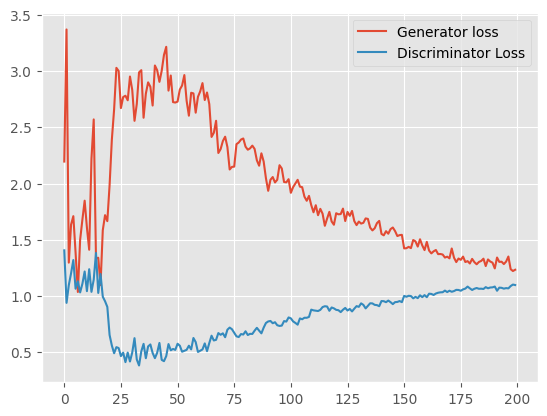

In [14]:
# 코드 13-33 생성자와 판별자의 오차 확인
plt.figure()
losses_g = [fl.item() for fl in losses_g]
plt.plot(losses_g, label="Generator loss")
losses_d = [f2.item() for f2 in losses_d]
plt.plot(losses_d, label="Discriminator Loss")
plt.legend()

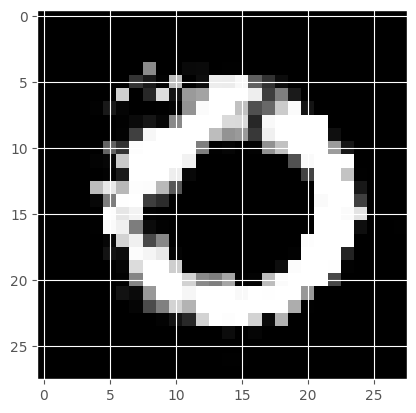

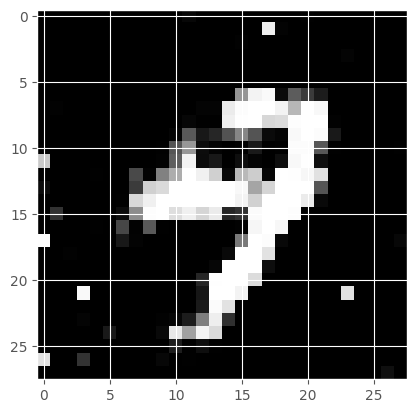

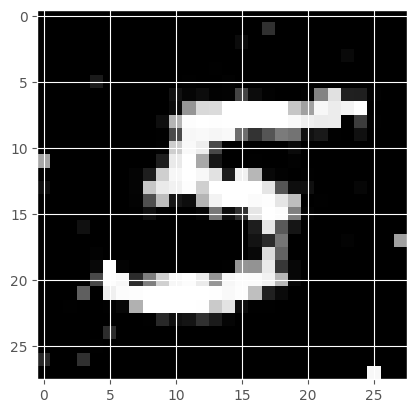

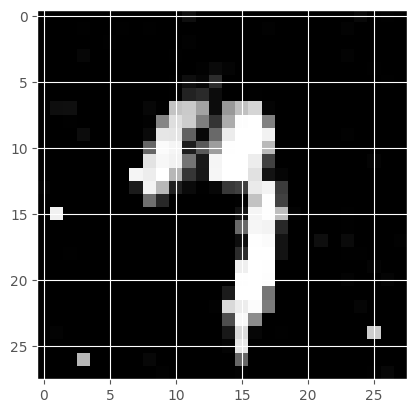

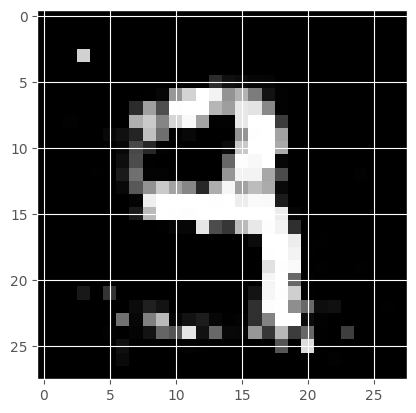

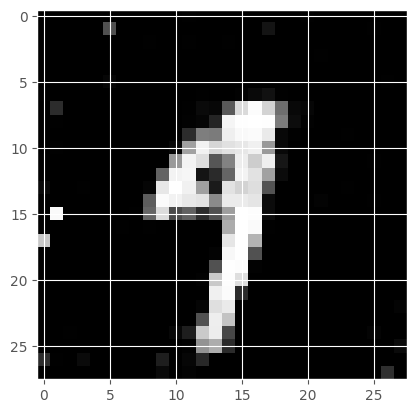

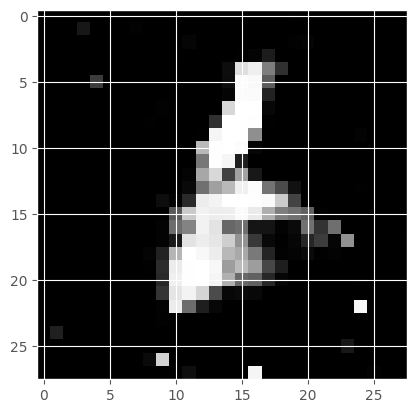

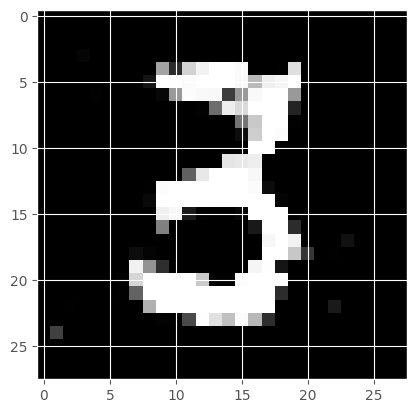

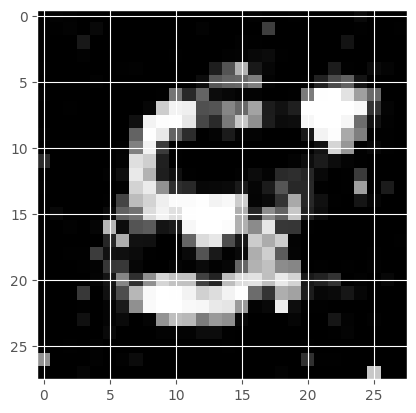

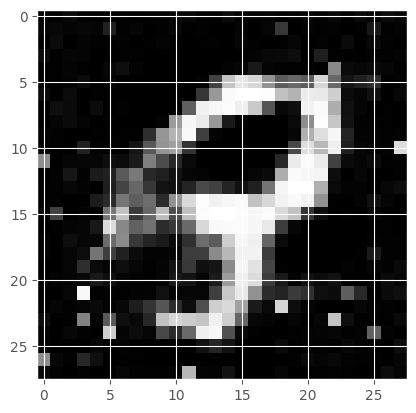

In [15]:
# 코드 13-34 생성된 이미지 출력
import numpy as np

fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap="gray")
    plt.savefig("../chap13/img/fake_images_img" + str(i) + ".png")
    plt.show()